TokaMaker Example: Equilibria with toroidally non-continuous conductors in LTX {#doc_tMaker_LTX_ex2}
==========
In this example we show how toroidally non-continuous conductors can be used to model different conditions in LTX-&beta;, including:
 1. Computing eddy currents during the OH pre-charge
 2. Solving for an two sequential "inverse" equilibria, with self-consistent eddy currents between them
 3. Computing vessel and plasma eigenmodes

This example utilizes the mesh built in \ref doc_tMaker_LTX_ex1.

**Warning:** Toroidally non-continuous conducting regions are still in development. Please be careful when using this feature and report any issues.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_spline_flux_fun

## Setup solver

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_eddy_modes
Revision id:          7d8d883
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_LTX_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh()". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()" to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

We also increase the maximum number of Picard iterations in the equilibrium solve to 80 from the default of 40.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('LTX_mesh.h5')
cond_dict_vv = copy.deepcopy(cond_dict)
cond_dict_vv['SHELLU']['eta']=1.E2
cond_dict_vv['SHELLL']['eta']=1.E2
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict_vv,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3211
    # of edges   =    9490
    # of cells   =    6280
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.318E-02
    hmax =  7.276E-02
  Surface grounded at vertex     649


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.4339999999999999E-003


Longest L/R time = 4.3353E-03 [s]


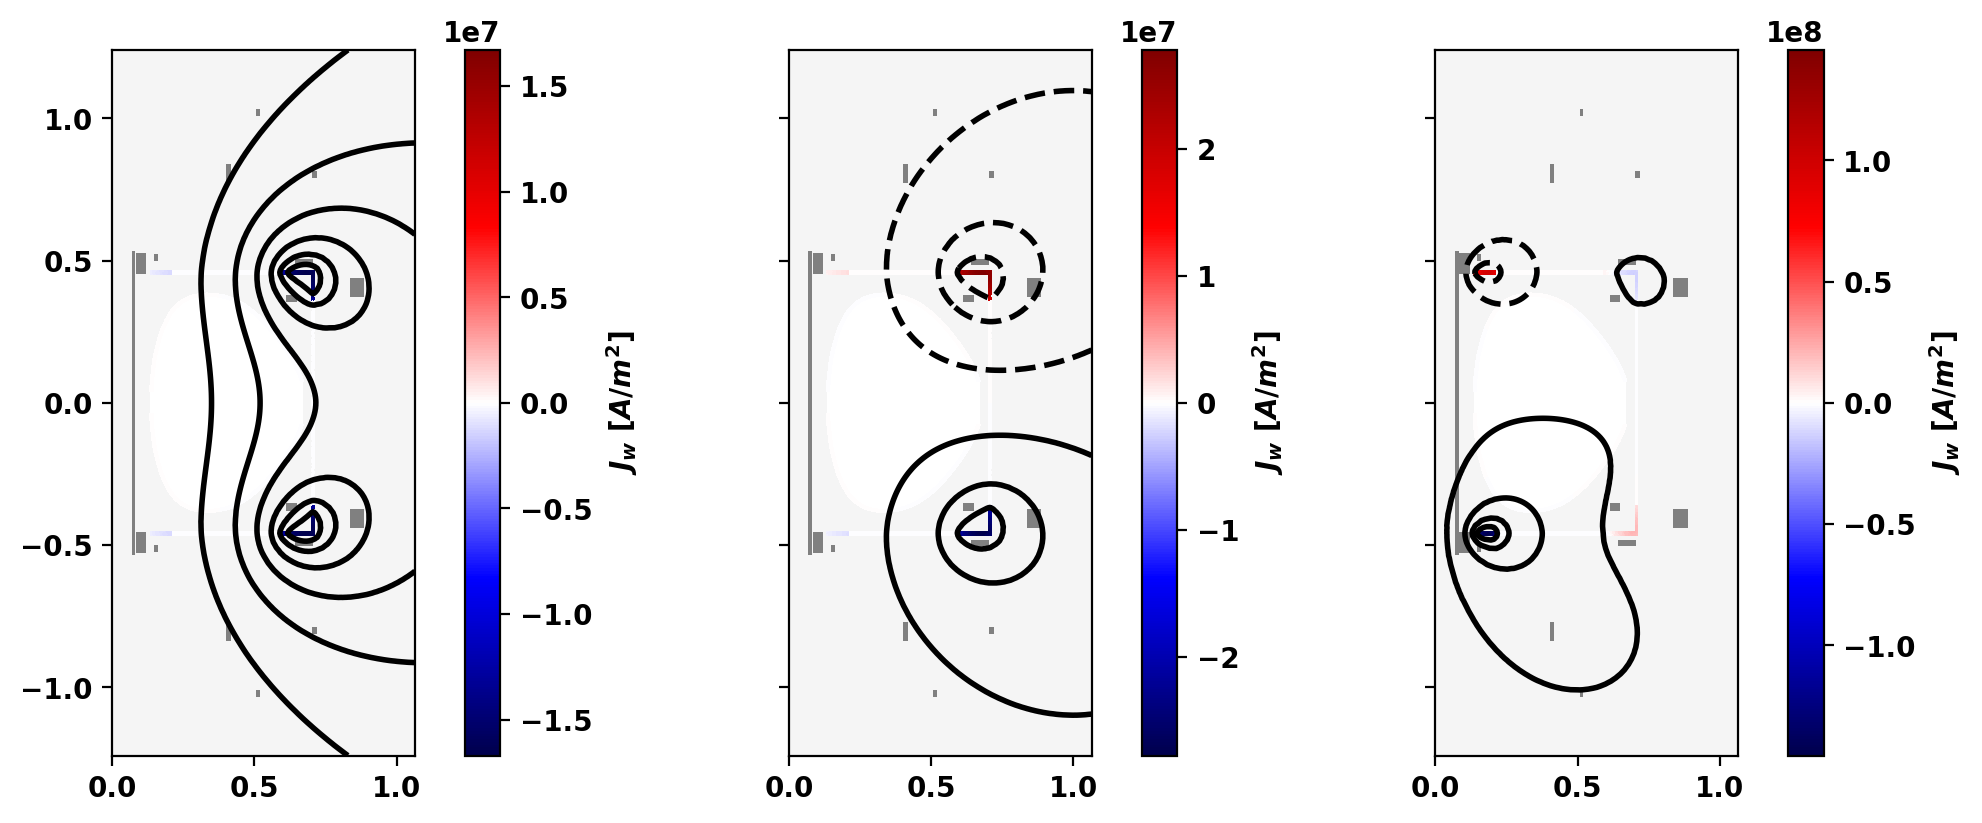

In [5]:
psi0 = mygs.get_psi(False)
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
for i in range(3):
    mygs.plot_machine(fig,ax[i],limiter_color=None)
    mygs.plot_psi(fig,ax[i],eig_vecs[i,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
    mygs.plot_eddy(fig,ax[i],dpsi_dt=eig_vecs[i,:]*abs(eig_vals[i,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))
vv_eigs = eig_vecs.copy()

In [6]:
mygs.reset()
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3211
    # of edges   =    9490
    # of cells   =    6280
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.318E-02
    hmax =  7.276E-02
  Surface grounded at vertex     649


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.4499999999999999E-003


### Define a vertical stability coil
Like many elongated equilibria, the equilibria we seek to compute below are vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use the "INTERNAL" coils, but in practice this stability is likely provided largely by the shell when plasma are sufficiently elongated.

In [7]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[mygs.coil_sets['INTERNALU']['id'], mygs.coil_sets['INTERNALL']['id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Compute Decay Modes of Conductor System
Here we compute the decay modes (L/R eigenvalues) of the conductors in our model.

Longest L/R time = 5.1504E-03 [s]


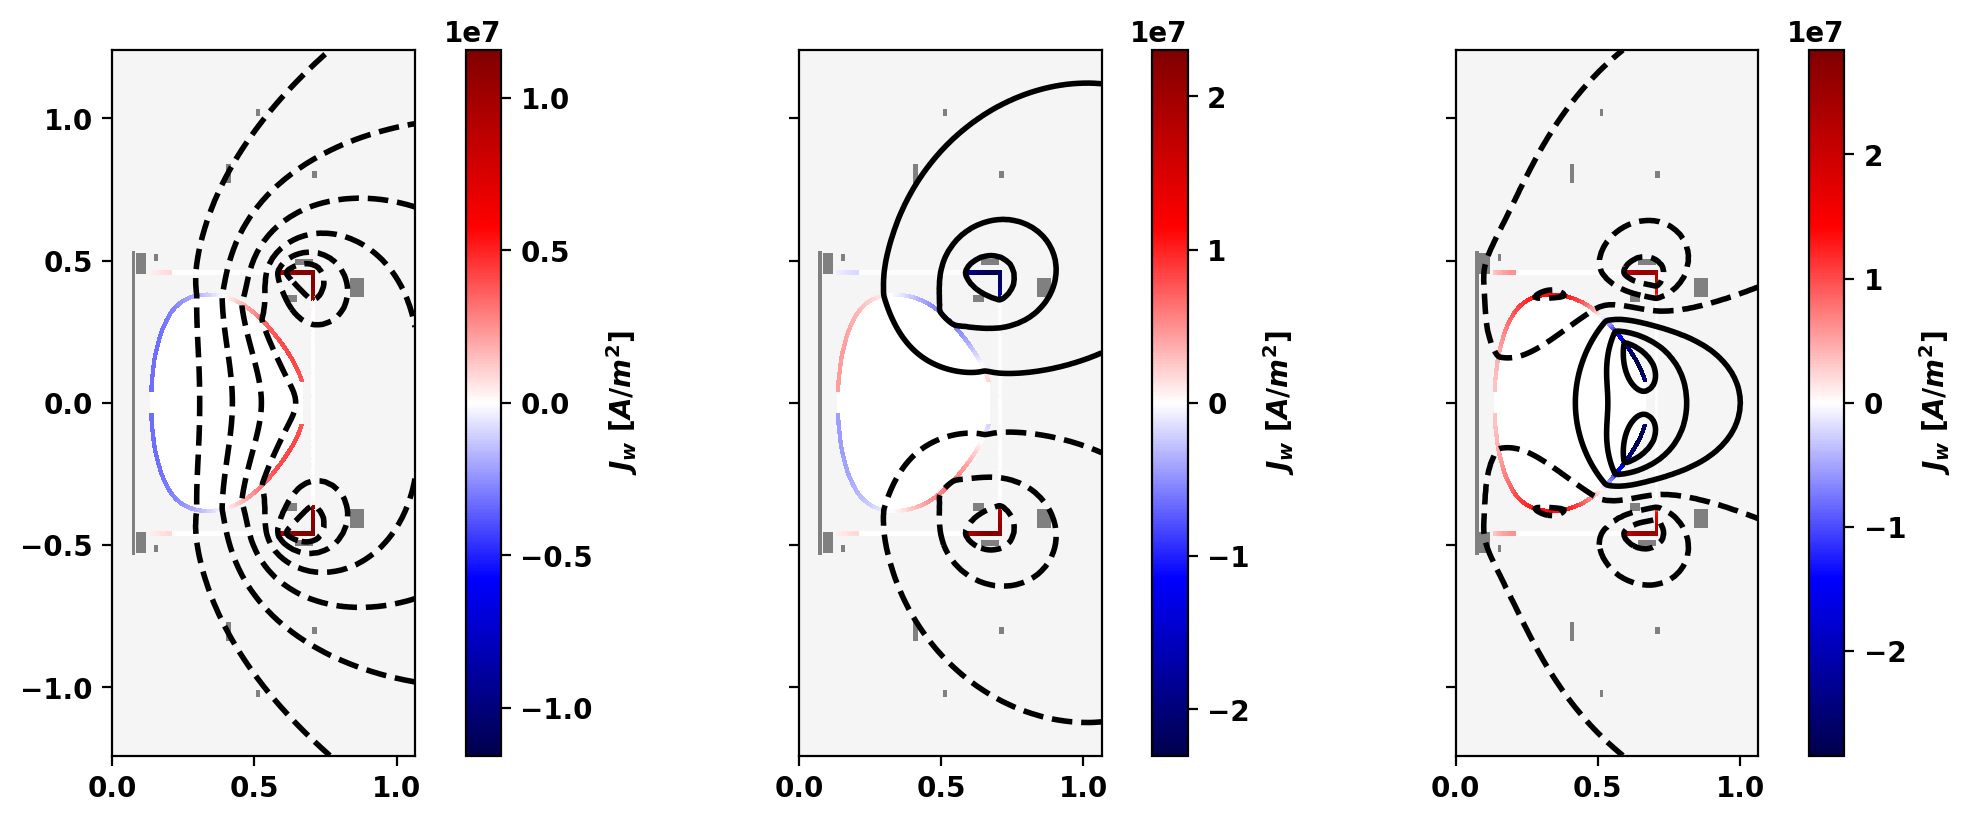

In [8]:
psi0 = mygs.get_psi(False)
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
for i in range(3):
    mygs.plot_machine(fig,ax[i],limiter_color=None)
    mygs.plot_psi(fig,ax[i],eig_vecs[i,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
    mygs.plot_eddy(fig,ax[i],dpsi_dt=eig_vecs[i,:]*abs(eig_vals[i,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))

In [10]:
neigs = np.zeros((10,),dtype=np.int32)
neigs[0] = 3
cond_eigs = np.vstack((eig_vecs[0,:],vv_eigs[[0,2],:]))
mygs.set_cond_modes(neigs,cond_eigs)

          10           0
          10           3


### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use a simple cubic flux function, using \ref OpenFUSIONToolkit.TokaMaker.util.create_spline_flux_fun "create_spline_flux_fun()", with the same shape for both F\*F' and P'. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

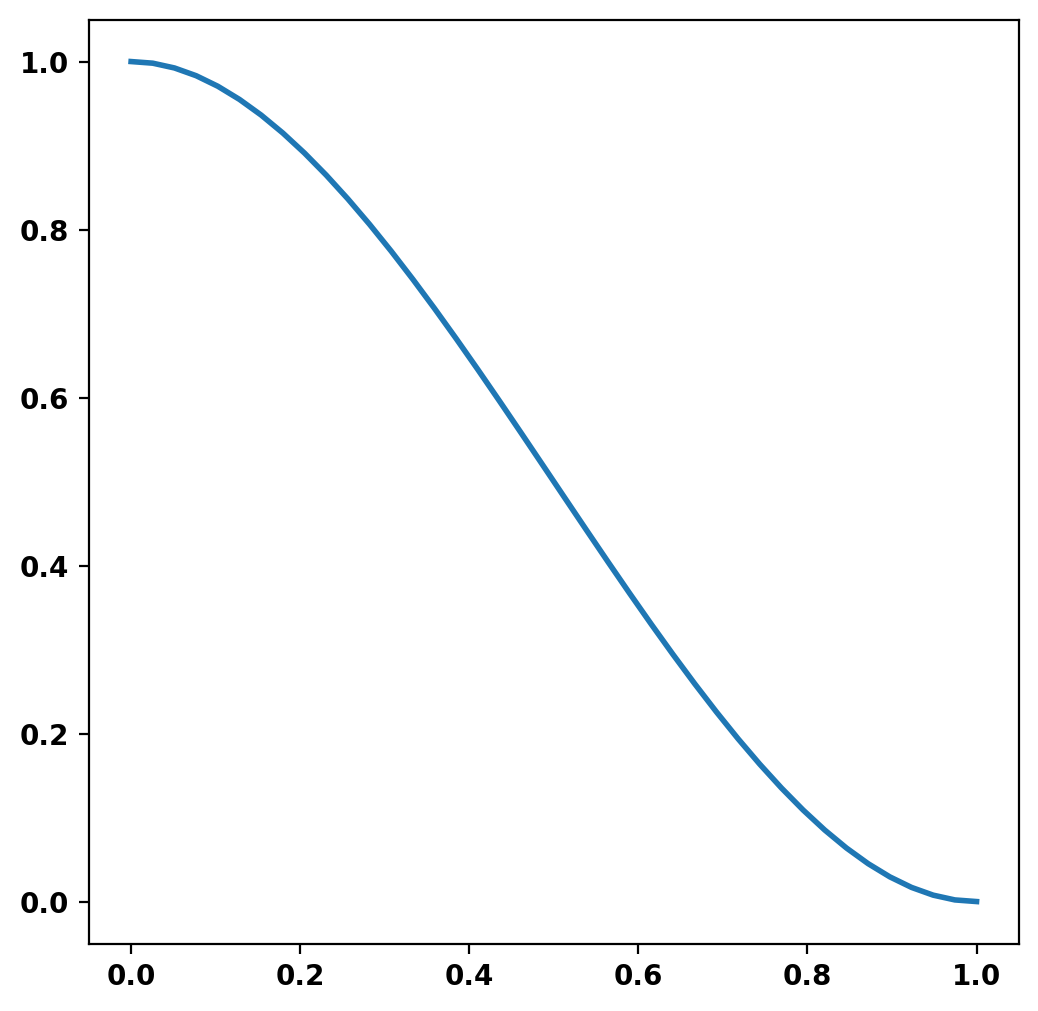

In [11]:
prof = create_spline_flux_fun(40,[0.0,0.5,1.0],[1.0,0.5,0.0],axis_bc=[1,0.0],edge_bc=[1,0.0])
plt.plot(prof['x'],prof['y'])
mygs.set_profiles(ffp_prof=prof,pp_prof=prof)

### Compute equilibrium 5 ms later

In [12]:
import pickle
with open('constraints.pkl','rb') as fid:
    exp_data = pickle.load(fid)

In [13]:
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction
myrecon = reconstruction(mygs)
floop_locs = []
floop_vals = []
for floop in exp_data['floops']:
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        floop_locs.append(floop['loc'])
        floop_vals.append(-floop['val'])
        print(floop['loc'],floop['val'])
        myrecon.add_flux_loop(floop['loc'],-floop['val'], err=abs(floop['val']*0.05))
myrecon.set_Ip(-exp_data['Ip'], err=abs(0.05*exp_data['Ip']))

[0.1448 0.1961] 0.03004877117739638
[0.2015 0.3342] 0.03351743697207083
[0.2887 0.3933] 0.035547027370220106
[0.4034 0.3862] 0.041677696628700675
[0.5394 0.2941] 0.04831095830648843
[0.6252 0.1846] 0.050813734528433005
[0.6767 0.0824] 0.05151383683319951
[ 0.1211 -0.046 ] 0.028760991932791278
[ 0.1398 -0.208 ] 0.027974149544690397
[ 0.1958 -0.3318] 0.031144487633999168
[ 0.2871 -0.3917] 0.03300203215812742
[ 0.4006 -0.3854] 0.03786420004013386
[ 0.5404 -0.2941] 0.04602398136739786
[ 0.6192 -0.1965] 0.05003542801292931


In [14]:
# Replace shape constraints with absolute flux and current constraints
mygs.set_isoflux(None)
mygs.set_saddles(None)
mygs.set_targets(Ip=-exp_data['Ip'],Ip_ratio=2.0)
mygs.set_flux(np.array(floop_locs),np.array(floop_vals)/2.0/np.pi)

# Set coil regularization to weekly track measured coil currents
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E1*np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))
coil_reg_weights[-1] = 1.E2
for name, coil in mygs.coil_sets.items():
    if name[-1] == 'U' or name[-1] == 'L':
        name = name[:-1]
    print(name,exp_data['coils'][name.lower()])
    coil_reg_targets[coil['id']] = -exp_data['coils'][name.lower()]

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

# Initial equilibrium with very rough guess
err_flag = mygs.init_psi(0.42,0.0,0.15,1.5,0.6)

# Update maximum number of solver iterations
mygs.settings.maxits=100
mygs.settings.urf=0.4
mygs.update_settings()

# Compute initial equilibrium
err_flag = mygs.solve()

RED 2044.1307304310892
RED 2044.1307304310892
ORANGE 2094.1074552690166
ORANGE 2094.1074552690166
YELLOW -2718.7357747451188
YELLOW -2718.7357747451188
GREEN 762.5755263217904
GREEN 762.5755263217904
BLUE 3665.406281464167
BLUE 3665.406281464167
INTERNAL 11.495868120904863
INTERNAL 11.495868120904863
OH 22387.266393807764
Starting non-linear GS solver
     1  6.2865E-01  1.1780E+00  1.3389E-03  4.0342E-01 -7.8765E-03  5.3413E-03
     2  7.4027E-01  1.3541E+00  7.3373E-04  4.0393E-01 -8.9584E-03  9.2275E-03
     3  7.9937E-01  1.4404E+00  4.2103E-04  4.0503E-01 -9.7440E-03  1.1755E-02
     4  8.3389E-01  1.4865E+00  2.6013E-04  4.0623E-01 -1.0383E-02  1.3721E-02
     5  8.5524E-01  1.5120E+00  1.7463E-04  4.0736E-01 -1.0932E-02  1.5376E-02
     6  8.6884E-01  1.5261E+00  1.2640E-04  4.0838E-01 -1.1416E-02  1.6820E-02
     7  8.7768E-01  1.5337E+00  9.7118E-05  4.0927E-01 -1.1850E-02  1.8106E-02
     8  8.8350E-01  1.5375E+00  7.7967E-05  4.0998E-01 -1.2248E-02  1.9265E-02
     9  8.8739

In [15]:
field_eval = mygs.get_field_eval('PSI')
for floop in exp_data['floops']:
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        B_tmp = field_eval.eval(floop['loc'])
        print(floop['loc'],-floop['val']/2.0/np.pi,B_tmp[0])

[0.1448 0.1961] -0.004782410466719906 -0.004711727726619925
[0.2015 0.3342] -0.005334465773876122 -0.005392426437855768
[0.2887 0.3933] -0.0056574851181934276 -0.006035911738813824
[0.4034 0.3862] -0.006633211435142134 -0.00677193465471839
[0.5394 0.2941] -0.007688927819984095 -0.007666708425702369
[0.6252 0.1846] -0.008087257027159433 -0.008243714770039937
[0.6767 0.0824] -0.00819868176963305 -0.008302567402892463
[ 0.1211 -0.046 ] -0.0045774540343298566 -0.00451496054596396
[ 0.1398 -0.208 ] -0.00445222417882937 -0.004659968718661288
[ 0.1958 -0.3318] -0.004956799157015376 -0.005043802193814274
[ 0.2871 -0.3917] -0.0052524365500436695 -0.005509642186141142
[ 0.4006 -0.3854] -0.006026274602607646 -0.006168683367760402
[ 0.5404 -0.2941] -0.007324944135390658 -0.007032552796919321
[ 0.6192 -0.1965] -0.00796338569797639 -0.007698521198340191


### Plot equilibrium
We now show the updated equilibrium, this time using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" to show the eddy currents in the vessel due to the change in flux from the preceding equilibrium.

Starting CG solver
     0  0.000000E+00  0.000000E+00  3.698603E-01
     1 -5.489790E+02  3.785398E+03  1.797460E-01  4.748405E-05
     2 -6.515252E+02  3.989841E+03  7.404473E-02  1.855831E-05
     3 -6.678983E+02  4.075579E+03  2.591082E-02  6.357579E-06
     4 -6.702956E+02  4.088868E+03  1.089627E-02  2.664861E-06
     5 -6.706307E+02  4.088172E+03  3.771561E-03  9.225542E-07
     6 -6.706788E+02  4.082032E+03  1.463873E-03  3.586138E-07
     7 -6.706869E+02  4.082183E+03  5.641385E-04  1.381953E-07
     8 -6.706879E+02  4.082436E+03  2.716075E-04  6.653074E-08
     9 -6.706882E+02  4.082506E+03  9.414212E-05  2.305989E-08
    10 -6.706882E+02  4.082572E+03  3.251202E-05  7.963612E-09
    20 -6.706882E+02  4.082553E+03  2.371382E-09  5.808576E-13
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.0326E+05
  Current Centroid [m]    =    0.385 -0.017
  Magnetic Axis [m]       =    0.413 -0.017
  Elongation              =    1.189 (U:  1.181

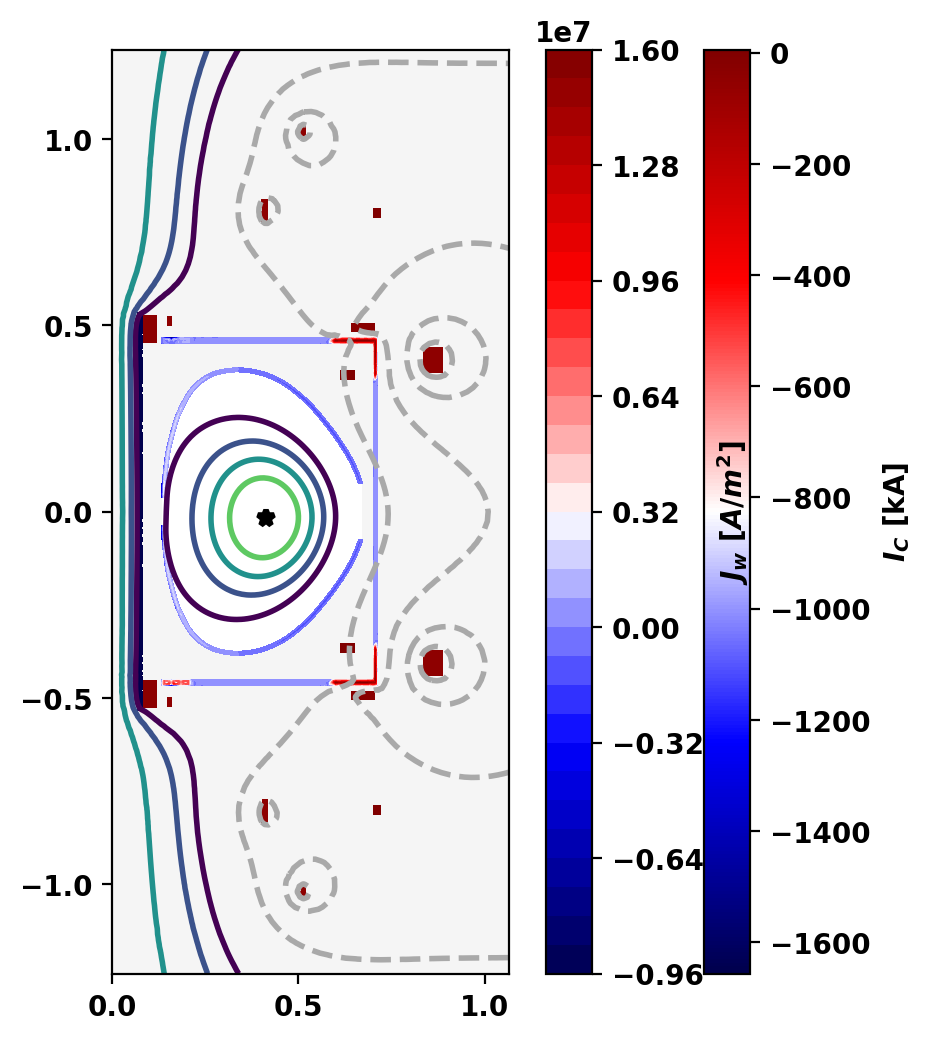

In [16]:
# Plot equilibrium
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-3,coil_clabel=r'$I_C$ [kA]',coil_symmap=False,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_eddy(fig,ax,psi=mygs.get_psi(False),colormap='seismic')#,symmap=True)
mygs.plot_constraints(fig, ax)
# Print information and coil currents
mygs.print_info()
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E3))

In [17]:
# Remove all shape constraints
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)

# Set initial position targets from current values
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])

# Set reconstruction settings
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.fitCoils = False
myrecon.settings.pm = False

# Perform reconstructions
err_flag = myrecon.reconstruct()


*** Loading fit constraints ***
 Fixed           3           3

Starting Fit:
  # of free parameters   =    5
  # of constraints       =   15

Function evaluation    1
  Alam              =  8.972E-01
  P_scale           =  1.535E+00
  R0_target         =  4.132E-01
  V0_target         = -1.666E-02
  Cond weights      =  2.666E-01  7.207E-01  4.773E-03
  Maximum Rel Error =  6.683E-02
  Maximum Abs Error =  1.108E+00
  Total Weighted Error   =  2.374E+00
  RMS Weighted Error     =  6.130E-01

Function evaluation    2
  Alam              =  8.972E-01
  P_scale           =  1.535E+00
  R0_target         =  4.132E-01
  V0_target         = -1.666E-02
  Cond weights      =  2.666E-01  7.207E-01  4.773E-03
  Maximum Rel Error =  6.683E-02
  Maximum Abs Error =  1.129E+00
  Total Weighted Error   =  2.374E+00
  RMS Weighted Error     =  6.130E-01

Gradient evaluation     1

Function evaluation    3
  Alam              =  7.357E-01
  P_scale           =  2.142E+00
  R0_target         =  4.207

In [18]:
mygs.print_info()

print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E3))

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.0253E+05
  Current Centroid [m]    =    0.391 -0.017
  Magnetic Axis [m]       =    0.419 -0.017
  Elongation              =    1.190 (U:  1.174, L:  1.206)
  Triangularity           =    0.179 (U:  0.152, L:  0.206)
  Plasma Volume [m^3]     =    0.442
  q_0, q_95               =    0.781  3.940
  Peak Pressure [Pa]      =    5.4345E+03
  Stored Energy [J]       =    8.1444E+02
  <Beta_pol> [%]          =   45.2543
  <Beta_tor> [%]          =    3.7512
  <Beta_n>   [%]          =    2.3673
  Diamagnetic flux [Wb]   =    1.2004E-03
  Toroidal flux [Wb]      =    6.6677E-02
  l_i                     =    1.1907

Coil Currents [kA]:
  REDU:           -2.04
  REDL:           -2.05
  ORANGEU:        -2.09
  ORANGEL:        -2.09
  YELLOWU:         2.72
  YELLOWL:         2.72
  GREENU:         -0.76
  GREENL:         -0.76
  BLUEU:          -3.66
  BLUEL:          -3.67
  INTERNALU:       0.07
  

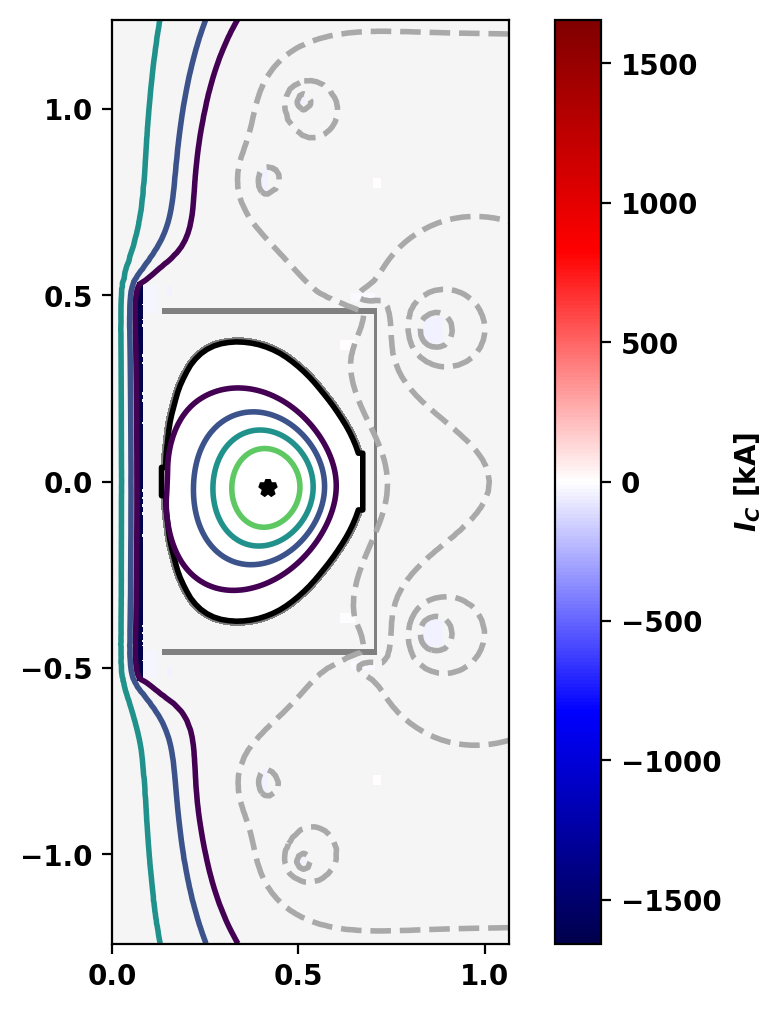

In [19]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-3,coil_clabel=r'$I_C$ [kA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)